In [17]:
#Classification using neural network
#Using pre-trained deep convolutional neural network "ResNet 50"

In [18]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import imutils
from skimage import color
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from keras.models import Sequential,Model
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import PIL as image_lib
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
#from keras.layers.core import Dense
#from tensorflow.keras.layers import dense
from sklearn.metrics import confusion_matrix,classification_report

import itertools 
import datetime

import io

In [19]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

x_train = [] # training images.
y_train  = [] # training labels.
x_test = [] # testing images.
y_test = [] # testing labels.

image_size = 200


for label in labels:
    trainPath = os.path.join('cleaned/Training',label)
    for file in tqdm(os.listdir(trainPath)):
        image = cv2.imread(os.path.join(trainPath, file),0) # load images in gray.
        image = cv2.bilateralFilter(image, 2, 50, 50) # remove images noise.
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE) # produce a pseudocolored image
        image = cv2.resize(image, (image_size, image_size)) 
        x_train.append(image)
        y_train.append(labels.index(label))
    
    testPath = os.path.join('cleaned/Testing',label)
    for file in tqdm(os.listdir(testPath)):
        image = cv2.imread(os.path.join(testPath, file),0)
        image = cv2.bilateralFilter(image, 2, 50, 50)
        image = cv2.applyColorMap(image, cv2.COLORMAP_BONE)
        image = cv2.resize(image, (image_size, image_size))
        x_test.append(image)
        y_test.append(labels.index(label))


x_train = np.array(x_train) / 255.0 # normalize Images 
x_test = np.array(x_test) / 255.0

print(x_train.shape)
print(x_test.shape)


100%|███████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 207.05it/s]


(5712, 200, 200, 3)
(1311, 200, 200, 3)


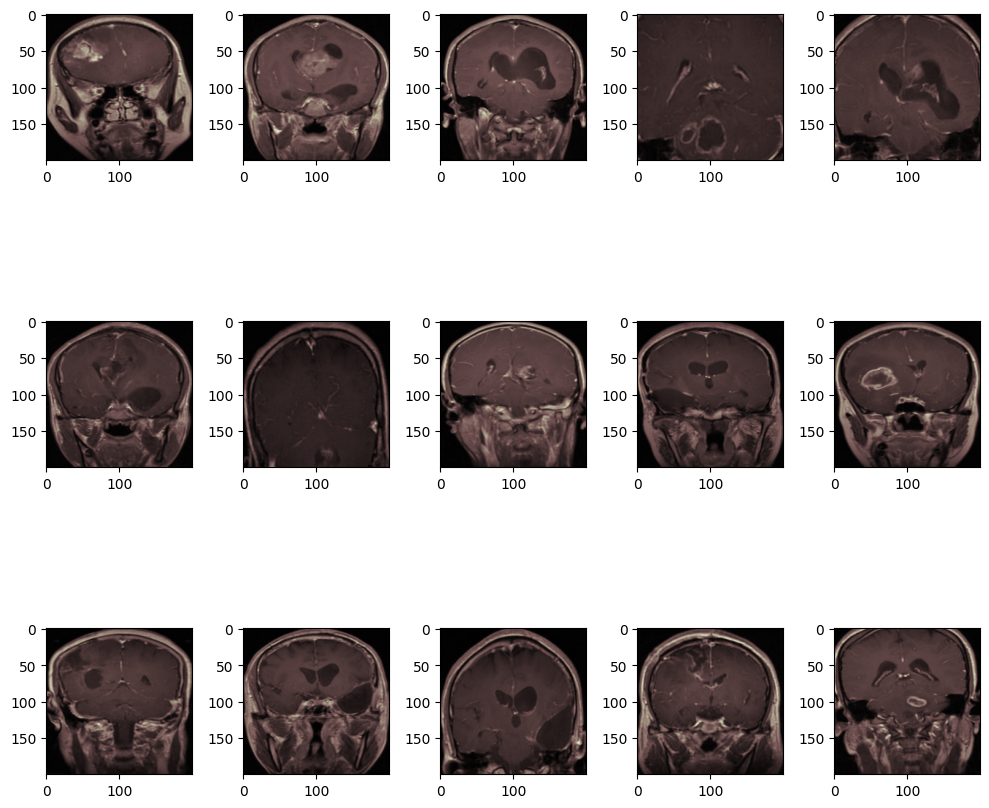

In [20]:
images = [x_train[i] for i in range(15)]
fig, axes = plt.subplots(3, 5, figsize = (10, 10))
axes = axes.flatten()
for img, ax in zip(images, axes):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [21]:
#randomize dataset
x_train, y_train= shuffle(x_train, y_train)
x_test, y_test= shuffle(x_test, y_test)


In [22]:
#one Hot Encoding on the labels
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)


In [23]:
print(x_train.shape)
print(x_test.shape)

(5712, 200, 200, 3)
(1311, 200, 200, 3)


In [24]:
#Augment data to reduce overfitting and improve accuracy
datagen = ImageDataGenerator(
    rotation_range=10,                        
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True)

datagen.fit(x_train)


In [25]:
net = ResNet50(
    weights='imagenet', # Load weights pre-trained on ImageNet.
     include_top=False, 
     input_shape=(image_size,image_size,3))

In [26]:
model = net.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.4)(model)
model = Dense(4, activation="softmax")(model)
model = Model(inputs= net.input, outputs= model)

#compile our model.
adam = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=adam, loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 206, 206, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 100, 100, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [27]:



class_names = list(labels)
def plot_to_image(figure):    
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)

    digit = tf.image.decode_png(buf.getvalue(), channels=4)
    digit = tf.expand_dims(digit, 0)

    return digit

def plot_confusion_matrix(cm, class_names): 
    figure = plt.figure(figsize=(8, 8)) 
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Accent) 
    plt.title("Confusion matrix") 
    plt.colorbar() 
    tick_marks = np.arange(len(class_names)) 
    plt.xticks(tick_marks, class_names, rotation=45) 
    plt.yticks(tick_marks, class_names)

    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)  
    threshold = cm.max() / 2. 

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):   
        color = "white" if cm[i, j] > threshold else "black"   
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)  
    
    plt.tight_layout() 
    plt.ylabel('True label') 
    plt.xlabel('Predicted label') 

    return figure


def log_confusion_matrix(epoch, logs):
    predictions = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(np.argmax(y_test,axis=1), predictions)
    figure = plot_confusion_matrix(cm, class_names=class_names)
    cm_image = plot_to_image(figure)
    
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)



logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))


     

In [28]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)



(5712, 200, 200, 3)
(5712, 4)
(1311, 200, 200, 3)
(1311, 4)


In [29]:
file_writer_cm = tf.summary.create_file_writer(logdir)


BATCH_SIZE = 64
EPOCHS = 50

Checkpoint = ModelCheckpoint(filepath = 'model-{epoch:02d}-{val_accuracy:.2f}-{val_loss:.2f}.h5',monitor = 'val_loss', verbose = 1, save_best_only = True,mode = 'min')

ES = EarlyStopping(monitor = 'val_loss',min_delta = 0.001,patience = 5,mode = 'min',restore_best_weights = True,verbose = 1)

RL = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.3,patience = 5,verbose = 1,mode = 'min')

callbacks = [ES,RL,Checkpoint,LambdaCallback(on_epoch_end=log_confusion_matrix)]

history = model.fit(datagen.flow(x_train, y_train, batch_size=20),validation_data = (x_test,y_test),epochs = EPOCHS,callbacks = callbacks)


Epoch 1/50
286/286 [==============================] - ETA: 0s - loss: 0.3049 - accuracy: 0.8920
Epoch 1: val_loss improved from inf to 10.66764, saving model to model-01-0.23-10.67.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 937s 3s/step - loss: 0.3049 - accuracy: 0.8920 - val_loss: 10.6676 - val_accuracy: 0.2288 - lr: 1.0000e-04
Epoch 2/50
286/286 [==============================] - ETA: 0s - loss: 0.1290 - accuracy: 0.9583
Epoch 2: val_loss improved from 10.66764 to 3.85640, saving model to model-02-0.25-3.86.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 955s 3s/step - loss: 0.1290 - accuracy: 0.9583 - val_loss: 3.8564 - val_accuracy: 0.2464 - lr: 1.0000e-04
Epoch 3/50
286/286 [==============================] - ETA: 0s - loss: 0.0710 - accuracy: 0.9774
Epoch 3: val_loss improved from 3.85640 to 2.51771, saving model to model-03-0.46-2.52.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 953s 3s/step - loss: 0.0710 - accuracy: 0.9774 - val_loss: 2.5177 - val_accuracy: 0.4569 - lr: 1.0000e-04
Epoch 4/50
286/286 [==============================] - ETA: 0s - loss: 0.0552 - accuracy: 0.9839
Epoch 4: val_loss improved from 2.51771 to 0.32973, saving model to model-04-0.89-0.33.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 964s 3s/step - loss: 0.0552 - accuracy: 0.9839 - val_loss: 0.3297 - val_accuracy: 0.8909 - lr: 1.0000e-04
Epoch 5/50
286/286 [==============================] - ETA: 0s - loss: 0.0532 - accuracy: 0.9844
Epoch 5: val_loss did not improve from 0.32973
286/286 [==============================] - 965s 3s/step - loss: 0.0532 - accuracy: 0.9844 - val_loss: 0.3828 - val_accuracy: 0.8947 - lr: 1.0000e-04
Epoch 6/50
286/286 [==============================] - ETA: 0s - loss: 0.0384 - accuracy: 0.9867
Epoch 6: val_loss improved from 0.32973 to 0.05343, saving model to model-06-0.98-0.05.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 958s 3s/step - loss: 0.0384 - accuracy: 0.9867 - val_loss: 0.0534 - val_accuracy: 0.9832 - lr: 1.0000e-04
Epoch 7/50
286/286 [==============================] - ETA: 0s - loss: 0.0638 - accuracy: 0.9799
Epoch 7: val_loss did not improve from 0.05343
286/286 [==============================] - 964s 3s/step - loss: 0.0638 - accuracy: 0.9799 - val_loss: 0.0638 - val_accuracy: 0.9832 - lr: 1.0000e-04
Epoch 8/50
286/286 [==============================] - ETA: 0s - loss: 0.0386 - accuracy: 0.9883
Epoch 8: val_loss improved from 0.05343 to 0.02706, saving model to model-08-0.99-0.03.h5


C:\Users\lvpra\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


286/286 [==============================] - 963s 3s/step - loss: 0.0386 - accuracy: 0.9883 - val_loss: 0.0271 - val_accuracy: 0.9908 - lr: 1.0000e-04
Epoch 9/50
286/286 [==============================] - ETA: 0s - loss: 0.0255 - accuracy: 0.9916
Epoch 9: val_loss did not improve from 0.02706
286/286 [==============================] - 958s 3s/step - loss: 0.0255 - accuracy: 0.9916 - val_loss: 0.0321 - val_accuracy: 0.9908 - lr: 1.0000e-04
Epoch 10/50
286/286 [==============================] - ETA: 0s - loss: 0.0267 - accuracy: 0.9925
Epoch 10: val_loss did not improve from 0.02706
286/286 [==============================] - 957s 3s/step - loss: 0.0267 - accuracy: 0.9925 - val_loss: 0.4098 - val_accuracy: 0.8665 - lr: 1.0000e-04
Epoch 11/50
286/286 [==============================] - ETA: 0s - loss: 0.0335 - accuracy: 0.9883
Epoch 11: val_loss did not improve from 0.02706
286/286 [==============================] - 956s 3s/step - loss: 0.0335 - accuracy: 0.9883 - val_loss: 0.0807 - val_accur

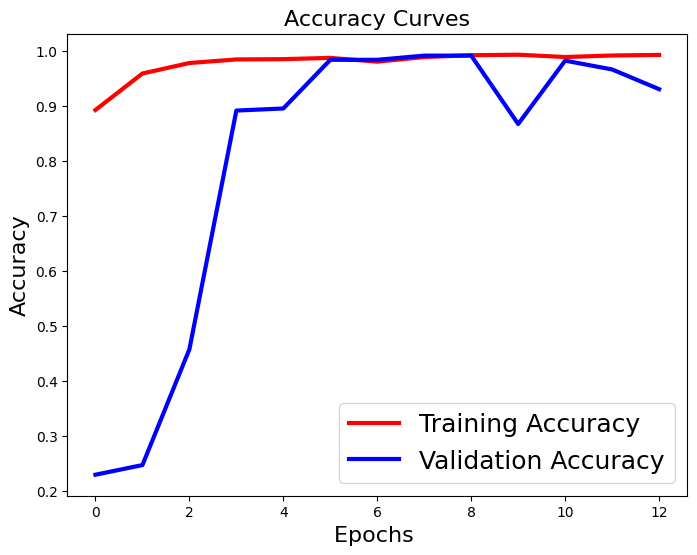

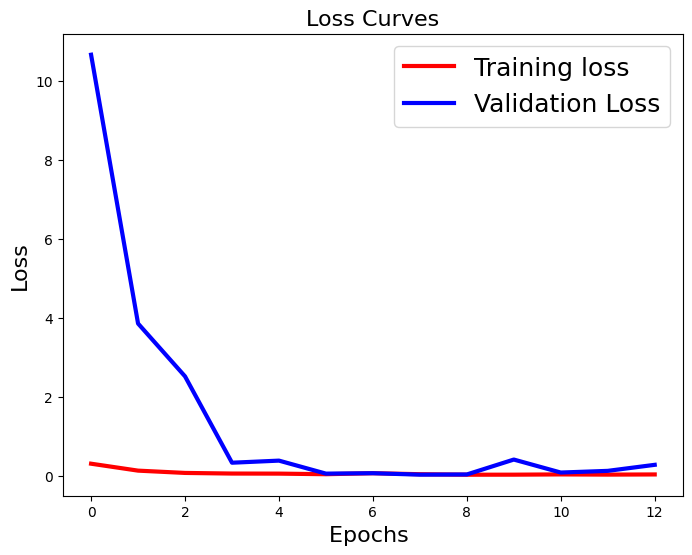

In [30]:

#Accuracy curve
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)   
plt.show()

#Loss Curve
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
plt.show()



41/41 [==============================] - 45s 1s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       300
           1       0.98      0.99      0.99       306
           2       1.00      1.00      1.00       405
           3       1.00      0.98      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



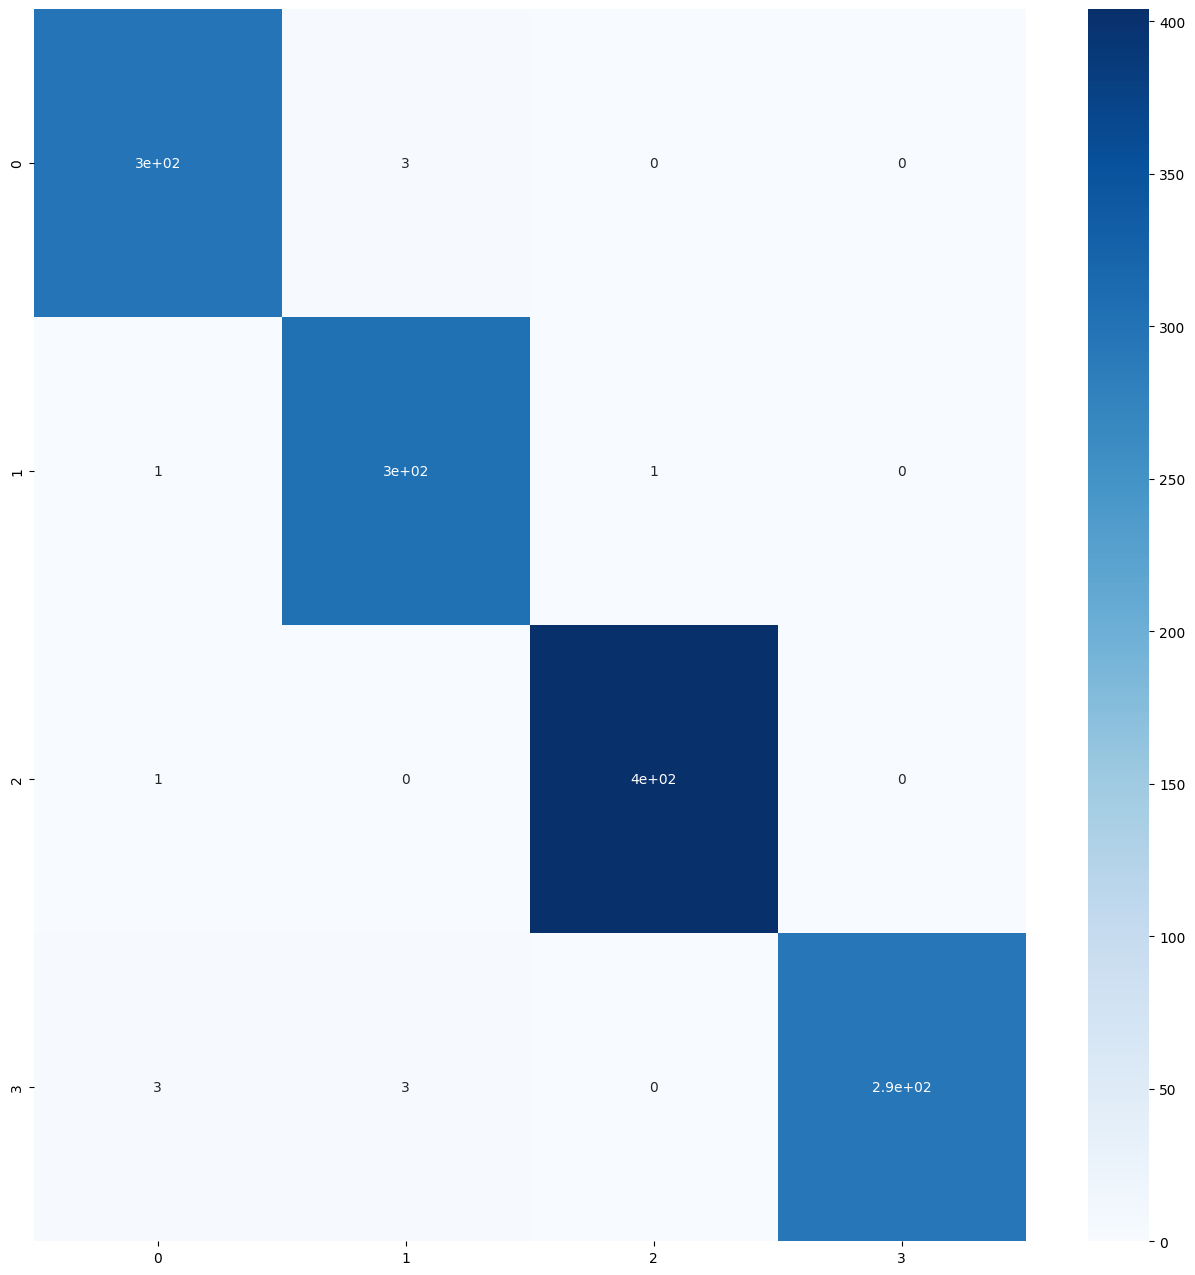

In [31]:
#Eval

predicted_classes = np.argmax(model.predict(x_test), axis = 1)
confusionmatrix = confusion_matrix(np.argmax(y_test,axis=1), predicted_classes)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)
print(classification_report(np.argmax(y_test,axis=1), predicted_classes))

In [32]:
loss,acc = model.evaluate(x_test,y_test)

41/41 [==============================] - 44s 1s/step - loss: 0.0271 - accuracy: 0.9908
